# Static parameter retrieval with RT1 and scipy optimize

This example shows how to use the [rt1 python package](https://github.com/raphaelquast/rt1_model) together with [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to setup a retrieval procedure to obtain a set of RT1 parameters from an incidence-angle dependent $\sigma^0$ dataset.

> **NOTE:** to run this example you need the additional dependencies [matplotlib](https://matplotlib.org/) and [ipympl](https://matplotlib.org/ipympl/).


In [1]:
%matplotlib widget
from rt1_model import RT1, surface, volume, set_loglevel
from scipy.optimize import least_squares
import numpy as np

set_loglevel("info")

## Specify simulation and fit parameters
### Set parameter values that are used to simulate the data

In [2]:
dB = True    # calculate values in decibel
sig0 = True  # calculate sigma0 values rather than intensities

noise_sigma = 0.5 if dB is True else 1e-3               # Noise-level (sigma of gaussian noise)
inc = np.random.normal(45, 10, (1000,)).clip(20, 70)    # Incidence angles
sim_params = dict(tau=0.3, omega=0.4, N=0.1, t_s=0.4)   # Simulation parameter values

### Set start values and boundaries for the fit

In [3]:
start_vals = dict(tau=0.1, omega=0.2, N=0.3, t_s=0.1)
bnd_vals = dict(tau=(0.01, 0.5), omega=(0.01, 0.5), N=(0.01, 0.5), t_s=(0.01, 0.5))

## Setup RT1 and create a simulated dataset

In [4]:
V = volume.Rayleigh()
SRF = surface.HG_nadirnorm(t="t_s", ncoefs=10)

R = RT1(V=V, SRF=SRF, int_Q=True, dB=dB, sig0=sig0)
R.NormBRDF = "N"  # Use a synonym for NormBRDF parameter

R.set_geometry(t_0=np.deg2rad(inc), p_0=0, geometry="mono")
R.update_params(**sim_params)

tot, surf, vol, inter = R.calc()
tot += np.random.normal(0, noise_sigma, tot.size)  # Add some random noise

17:22:57.747 INFO: Evaluating coefficients for interaction-term...
17:22:57.887 INFO: Coefficients extracted, it took 0.01525 sec.


## Setup scipy optimize to fit RT1 model to the data

In [5]:
param_names = list(sim_params)

def parse_params(x):
    """Map 1D parameter array to dict {parameter_name: value(s)}."""
    return dict(zip(param_names, x))

def fun(x):
    """Calculate residuals."""
    R.update_params(**parse_params(x))
    
    res = R.calc()[0] - tot
    return res


def jac(x):
    """Calculate jacobian."""
    R.update_params(**parse_params(x))

    # Transpose jacobian (as required by scipy.optimize)
    jac = np.array(R.jacobian(param_list=list(param_names))).T
    return jac


# Unpack start-values and boundaries as required by scipy optimize
x0 = [start_vals[key] for key in param_names]
bounds = list(zip(*[bnd_vals[key] for key in param_names]))

res = least_squares(
    fun=fun,
    x0=x0,
    bounds=bounds,
    jac=jac,
    ftol=1e-8,
    gtol=1e-8,
    xtol=1e-3,
    verbose=2,
)

found_params = dict(zip(param_names, res.x))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.6750e+03                                    1.47e+04    
       1              2         1.4418e+03      6.23e+03       1.48e-01       4.35e+03    
       2              3         5.1888e+02      9.23e+02       9.31e-02       1.56e+03    
       3              4         2.5596e+02      2.63e+02       1.09e-01       7.59e+02    
       4              5         1.5676e+02      9.92e+01       6.23e-02       2.94e+02    
       5              6         1.3942e+02      1.73e+01       5.19e-02       1.19e+02    
       6              8         1.3739e+02      2.03e+00       1.83e-02       3.69e+01    
       7              9         1.3598e+02      1.41e+00       3.59e-02       8.38e+01    
       8             10         1.3422e+02      1.76e+00       6.53e-02       5.14e+01    
       9             12         1.3401e+02      2.06e-01       7.52e-03       7.80e+00    

## Initialize analyzer widget and overlay results

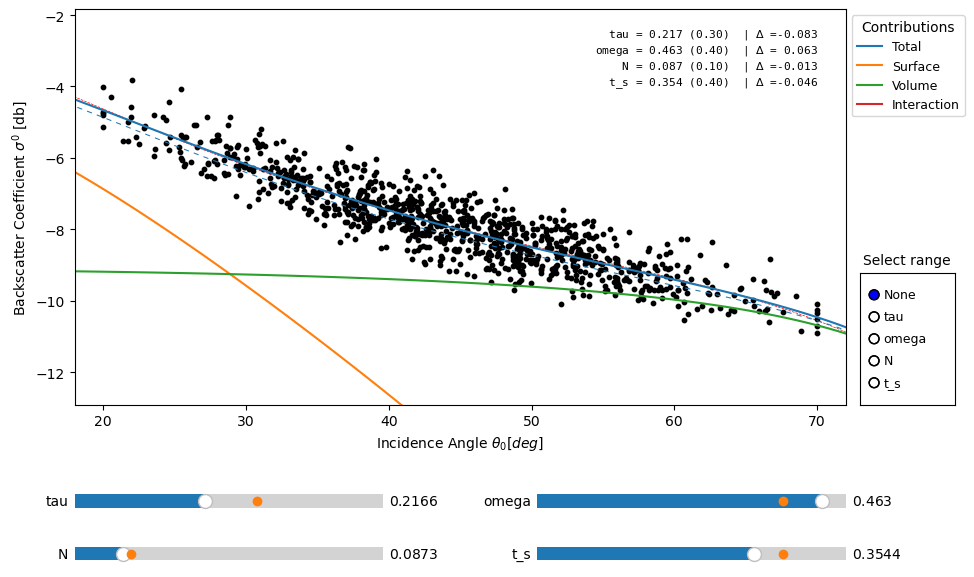

In [6]:
analyze_params = {key: (0.01, 0.5, found_params[key]) for key in param_names}
ana = R.analyze(param_dict=analyze_params)

# Plot fit-data on top
ana.ax.scatter(inc, tot, s=10, c="k")

ana.ax.plot(
    np.rad2deg(R.t_0).squeeze(),
    R.calc(**sim_params)[0].squeeze(),
    c="r",
    ls="--",
    lw=0.5,
    zorder=0,
)
ana.ax.plot(
    np.rad2deg(R.t_0).squeeze(),
    R.calc(**found_params)[0].squeeze(),
    c="C0",
    ls="--",
    lw=0.5,
    zorder=0,
)

# Set limits to fit-data range
ana.ax.set_xlim(inc.min() - 2, inc.max() + 2)
ana.ax.set_ylim(tot.min() - 2, tot.max() + 2)

# Indicate fit-results in slider-axes
for key, s in ana.sliders.items():
    if key in sim_params:
        s.ax.plot(sim_params[key], np.mean(s.ax.get_ylim()), marker="o")

# Add text
t = ana.f.text(
    0.6,
    0.95,
    "\n".join(
        [
            f"{key:>8} = {found:.3f} ({sim_params[key]:.2f})  "
            rf"| $\Delta$ ={found - sim_params[key]: .3f}"
            for (key, found) in found_params.items()
        ]
    ),
    va="top",
    fontdict=dict(family="monospace", size=8),
)